# Bridgerton Netflix Transcript Analysis 
- Dataset info and conversion:
    - Data from kaggle.com consisting of .rtf files of each episodes transcript
    - https://www.kaggle.com/datasets/amandam1/bridgerton-transcripts-cast
    - first convert files to .txt through keyboard commands on mac os
- import all libraries


In [1]:
#imports
import re
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer, PorterStemmer
import string
import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess
import pyLDAvis
#import pyLDAvis.sklearn
import pyLDAvis.gensim_models as gensimvis

import spacy

nltk.download([
     "names",
     "stopwords",
     "maxent_ne_chunker",
     "words",
     "movie_reviews",
     "averaged_perceptron_tagger",
    "vader_lexicon",
     "punkt",
    "wordnet",
    "omw-1.4"
 ])

[nltk_data] Downloading package names to /Users/katy/nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/katy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/katy/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /Users/katy/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /Users/katy/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/katy/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/katy/nltk_data...
[nltk_data]   Package vader_lexicon is already up-t

True

# Cleaning Data
- Dataset is unlabeled raw text 
- Create several functions to get the data in the desired format for NLP.
    - extract_sentences: custom function to get sentences from raw txt file
    - extract_season_episode: get season number and episode number from file name for tracking data
    - process_file: combines the first two functions to output Season, Episode, List of Sentences
    - tokenize_sentences: uses nltk word_tokenize function to get list of individual words
- Create dataframe consisting of Season, Episode, Sentences, Words
- Start NLP Text Analysis

In [112]:
def extract_sentences(file_path):
    #input: Txt file 
    #output: list of strings where each string is a sentence of dialogue from transcript
    #Note: speaker is NOT identified in the transcript reliably so speaker info is removed for ease of use
    #Note: Retains punctuation for each sentence, but removes any other within sentence symbols.
    #Note: There is a sent_tokenize nltk function that could also be used. 
    try:
        with open(file_path, 'r') as file:
            content = file.read()

        # Remove timestamps
        content = re.sub(r'\d{2}:\d{2}:\d{2} --> \d{2}:\d{2}:\d{2}', '', content)

        # Remove metadata lines
        content = re.sub(r'\[[^\]]+\]', '', content)

        # Remove all numbers
        content = re.sub(r'\d+', '', content)
        content = re.sub(r'-',' ',content)
        
        #reg exp pattern to split text into sentences
        sent_pattern = r'(?<=[.!?]) +'
        #use pattern to split text into sentences
        sentences = re.split(sent_pattern, content)
        # Strip leading and trailing whitespaces from sentences and spacing within sentences
        sentences = [sentence.strip() for sentence in sentences]
        cleaned_sentences = [re.sub(r'\s+', ' ', sentence.strip()) for sentence in sentences]
        #Remove any additional formatting within sentences such as \,;:
        cleaned_sentences = [sentence.replace("\'","").replace("\\","").replace("\"","") for sentence in cleaned_sentences]
        cleaned_sentences = [re.sub(r'[,;:]','',sentence) for sentence in cleaned_sentences]
        #remove sentences containing rtf formatting
        filtered_sentences = [sentence for sentence in cleaned_sentences if not re.search(r'{rtf.*?}',sentence)]
        #remove sentences that do not contain any letters
        filtered_sentences = [sentence for sentence in filtered_sentences if bool(re.search(r'[a-zA-Z]', sentence))]
         # Remove all punctuation
        filtered_sentences = [sentence.translate(str.maketrans('', '', string.punctuation)) for sentence in filtered_sentences]
        return filtered_sentences


    except FileNotFoundError:
        print("File not found.")
    except Exception as e:
        print("An error occurred:", e)

# Test
#file_path = 'episode_transcripts/bridgerton s2 ep8.txt'
#sentences = extract_sentences(file_path)
#print(sentences)
# Print each extracted sentence

#for i, sentence in enumerate(sentences, start=1):
#    print(f"Sentence {i}: {sentence}")




In [113]:
#extract season and episode number from file path
def extract_season_episode(file_path):
    filename = os.path.basename(file_path)
    season = re.search(r's(\d+)', filename).group(1)
    episode = re.search(r'ep(\d+)',filename).group(1)
    return season, episode

#Get season, episode, sentences for each file
def process_file(file_path):
    sentences = extract_sentences(file_path)
    season, episode = extract_season_episode(file_path)
    return season, episode, sentences 

def tokenize_sentences(sentences):
    #input: list of sentences
    #output: list of words
    #remove all punctuation first prior to using tokenize
    words = []
    for sentence in sentences:
        # Remove punctuation from the sentence
        sentence = sentence.translate(str.maketrans('', '', string.punctuation))
        tokens = word_tokenize(sentence)
        words.extend(tokens)
    #use nltk tokenize function 
    #words = [word_tokenize(sentence) for sentence in sentences]
    #flatten to single list not list of lists
    #words = [word for sentence in words for word in sentence]
    return words

In [114]:
#define folder path containing transcripts & get file names
folder_path = "episode_transcripts"
file_names = os.listdir(folder_path)
file_paths = [os.path.join(folder_path, file_name) for file_name in file_names if file_name.endswith(".txt")]
data = [process_file(file_path) for file_path in file_paths]
df = pd.DataFrame(data, columns = ['Season', 'Episode', 'Sentences'])
df = df.sort_values(by=['Season','Episode']).reset_index()

#add a 4th column containing a list of words
df['Words'] = df['Sentences'].apply(tokenize_sentences)


print(df['Sentences'])


0     [Dearest reader the time has come to place our...
1     [Push, Breathe, Yes, Yes, Your Grace I shall n...
2     [Some believe she is showing admirable foretho...
3     [The incomparable who captured the princes eye...
4     [Rose, Has my mother yet awakened, I did not o...
5     [Congratulations and stamina as they embark on...
6     [Would you please ask Miss Nolan if my persona...
7     [Of course Miss Leopold and her new husband wo...
8     [Whoa, I just think its important No no no, Gr...
9     [It has been said that competition is an oppor...
10    [All right take your time, Hes bloody huge, Ye...
11    [All right take your time, Hes bloody huge, Ye...
12    [Viscount Bridgerton, We thought perhaps youd ...
13    [It does not simply cover the length of the ch...
14    [A broken hearted bride to be, A royal wedding...
15    [Come on now, Come on now, Stay with me, My lo...
Name: Sentences, dtype: object


In [95]:

#initialize VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

#get sentiment scores for each sentence:
def get_sentiment_scores(sentences):
    scores = []
    for sentence in sentences:
        if isinstance(sentence, str):
            score = sid.polarity_scores(sentence)
            scores.append(score)
        else:
            print("Warning: Skipping non-string input:", sentence)
    return scores
# Get sentiment scores for each sentence
#scores = get_sentiment_scores(df['Sentences'].tolist())
#scores
#print(df['Sentences'])

## Can we use sentiment analysis to capture the overall emotional tone of each episode? 



In [117]:
# get sentiment scores for each row
def get_sentiment_scores_per_row(row):
    scores = []
    for sentence in row:
        score = sid.polarity_scores(sentence)
        scores.append(score)
    return scores

#aggregate sentiment scores for each row
def aggregate_sentiment_scores_per_row(scores):
    compound_scores = [score['compound'] for score in scores]
    overall_sentiment = sum(compound_scores) / len(compound_scores) #get average scores
    num_positive = sum(score['compound'] >= 0.05 for score in scores) 
    num_negative = sum(score['compound'] <= -0.05 for score in scores) 
    num_neutral = sum(-0.05 < score['compound'] < 0.05 for score in scores) 
    return {
        'overall_sentiment': overall_sentiment,
        'num_positive': num_positive,
        'num_negative': num_negative,
        'num_neutral': num_neutral
    }

# Apply sentiment analysis and aggregation to each row
df['sentiment_scores'] = df['Sentences'].apply(get_sentiment_scores_per_row)
df['aggregated_scores'] = df['sentiment_scores'].apply(aggregate_sentiment_scores_per_row)

# Extract aggregated scores for each row
df['overall_sentiment'] = df['aggregated_scores'].apply(lambda x: x['overall_sentiment'])
df['num_positive'] = df['aggregated_scores'].apply(lambda x: x['num_positive'])
df['num_negative'] = df['aggregated_scores'].apply(lambda x: x['num_negative'])
df['num_neutral'] = df['aggregated_scores'].apply(lambda x: x['num_neutral'])

# Print the DataFrame with aggregated scores
print(df.head())

   index Season Episode                                          Sentences  \
0     11      1       1  [Dearest reader the time has come to place our...   
1     13      1       2  [Push, Breathe, Yes, Yes, Your Grace I shall n...   
2     12      1       3  [Some believe she is showing admirable foretho...   
3     10      1       4  [The incomparable who captured the princes eye...   
4      9      1       5  [Rose, Has my mother yet awakened, I did not o...   

                                               Words  \
0  [Dearest, reader, the, time, has, come, to, pl...   
1  [Push, Breathe, Yes, Yes, Your, Grace, I, shal...   
2  [Some, believe, she, is, showing, admirable, f...   
3  [The, incomparable, who, captured, the, prince...   
4  [Rose, Has, my, mother, yet, awakened, I, did,...   

                                    sentiment_scores  \
0  [{'neg': 0.0, 'neu': 0.795, 'pos': 0.205, 'com...   
1  [{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compoun...   
2  [{'neg': 0.0, 'neu': 0.

All of the sentiment scores plotted below are close to zero which means the episodes come across as mostly neutral or very slightly positive when using standard bounds for VADER.  This is not surprising because the language used in Bridgerton is often nuanced, with subtle emotions and can be context dependent. The overall tone of Bridgerton is also more lighthearted and uplifting since it's a story about finding and exploring love with very minimal dark tones. The worst thing that seems to happen in the world of Bridgerton is someone being doomed to a spinster life or experiencing social ruin and being shamed by the Ton. Even with tuning we don't see major changes to sentiment with the standard use of the model. The language, grammar, and jargon used are fairly different in Bridgerton than in the trained VADER data. However, looking at the scores assigned sentence by sentence on a sample of data revealed fairly accurate results. I would need to independently label each sentence to check if the VADER output matches my reality through typical classification model metrics such as accuracy and recall.  

VADER (Valence Aware Dictionary and sEntiment Reasoner), a trained NLTK lexicon was purposefully created for use for sentiment analysis on social media posts. Providing VADER with a sentence (string) and asking for it's polarity results in an output between 0 to 1 for neutral, positive, and negative and a compound score deciding total consensus between -1 to 1 that can be tuned to reflect narrower or wider ranges between polarities. 
Source: https://github.com/cjhutto/vaderSentiment

Ideas for improving the output include: 
1. Aggregating smaller chunks of data. The episodes can be viewed in chunks of 20-30 sentences to see if the sentiment correctly corresponds with the flow of the show. 
2. Expanding VADER's dictionary of words and associated sentiment scores - VADER has a pre-defined set of words that is geared towards certain domains, if we adjust and improve this to capture the language of Bridgerton better, it might show more range in sentiment scores.
3. Creating a custom dictionary - A bridgerton diss or compliment might look a bit different than modern language and the text analysis could benefit from incorporating sentiment on sentence structures from other period romance pieces.
4. Parameter Tuning - We can play with the compound score bounds to see if we can narrow the neutral category so text that is very slightly positive or negative will be captured as positive or negative and not as neutral.
5. Label each sentence in the dataset manually with what is conveyed while watching the show. This method is likely to inject viewer bias, but provides a way to test if VADER is capturing sentiment of overall episode in line with a watcher by looking at the recall and accuracy of model. 

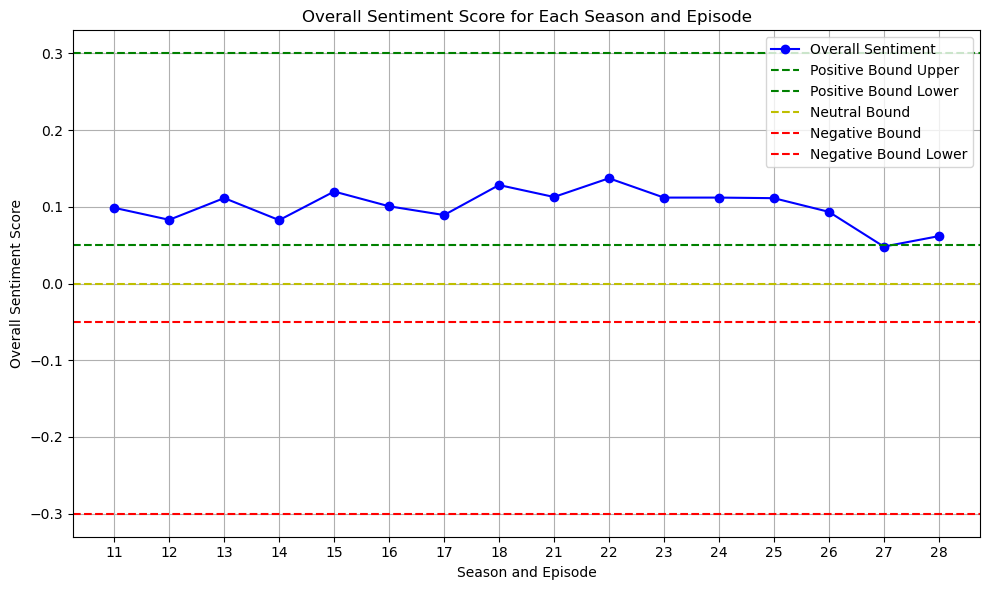

In [118]:
# Define positive, neutral, and negative sentiment bounds
positive_bound = 0.3
positive_bound_lower = 0.05
neutral_bound = 0
negative_bound = -0.3
negative_bound_lower = -0.05

# Plot overall sentiment
plt.figure(figsize=(10, 6))

# Plot sentiment data
plt.plot(df['Season'] + df['Episode'], df['overall_sentiment'], marker='o', linestyle='-', color='b', label='Overall Sentiment')

# Plot bounds
plt.axhline(y=positive_bound, color='g', linestyle='--', label='Positive Bound Upper')
plt.axhline(y=positive_bound_lower, color='g', linestyle='--', label='Positive Bound Lower')
plt.axhline(y=neutral_bound, color='y', linestyle='--', label='Neutral Bound')
plt.axhline(y=negative_bound, color='r', linestyle='--', label='Negative Bound')
plt.axhline(y=negative_bound_lower, color='r', linestyle='--', label='Negative Bound Lower')

# Set labels and title
plt.xlabel('Season and Episode')
plt.ylabel('Overall Sentiment Score')
plt.title('Overall Sentiment Score for Each Season and Episode')

# Set legend
plt.legend()

# Show plot
plt.grid(True)
plt.tight_layout()
plt.show()

## LDA (Latent Dirichlet Allocation) can be used to identify the main topics discussed in each episode. It's a type of soft clustering algorithm (unsupervised learning) which identifies latent topics or themes in documents or in this case transcripts of each episode. 
https://radimrehurek.com/gensim/models/ldamodel.html
The topics and themes identified by LDA are picked because they are statistically significant themes/topics within that dictionary. 

The dataset is fairly small for this technique which likes lots of data, so set expectations low for model performance. 

Preprocessing - we can try stemming: reducing words to their root (cooking and cooked become cook) or Lemmatizing: reducing words to it's root form using Part of Speech (POS) tagging and context. We can also identify trigrams and bigrams or multi word phrases to boost pattern recognition and gain better cluster results. 

Tradeoffs for stemming:
The Good: Reduce the number of words we're dealing with in the dictionary and improve processing outputs of the model. It's more of a crude heuristic approach so it's fast and efficient! 
The Bad: it can take some words to the root form that aren't intented to be such as cookie becoming cook or making up words entirely.

Tradeoffs for lemmatization: 
The Good: we are not just chopping the word, its a more data driven approach based on POS analysis and context to get real words
The Bad: It is computationally expensive

Bigram/Trigram identification: 
The Good: helps identify words frequently used together to boost cluster pattern recognition
The Bad: Can identify words that are not really used together (made up combinations). 

In [119]:
#Pre-Process Examples
#Stemming function
ps = PorterStemmer()
#lemmatization function
wnl = WordNetLemmatizer()
test_stem = df['Words'][0][15:35]
for word in test_stem:
    print ("{0:20}{1:20}{2:20}".format(word, ps.stem(word), wnl.lemmatize(word,pos='v')))

Consider            consid              Consider            
the                 the                 the                 
household           household           household           
of                  of                  of                  
the                 the                 the                 
Baron               baron               Baron               
Featherington       featherington       Featherington       
Three               three               Three               
misses              miss                miss                
foisted             foist               foist               
upon                upon                upon                
the                 the                 the                 
marriage            marriag             marriage            
market              market              market              
like                like                like                
sorrowful           sorrow              sorrowful           
sows                sow 

Porter Stemmer was selected since it appears to be the most popular stemming alogrithm in use. This represents the second column above.
Looking at the first 20 words from the Porter Stemmer implementation above shows some made up words such as:

* consider becoming consid
* marriage becoming marriag

The Lemmatize Algorithm selected was the WordNetLemmatizer which is column 3 above. Examing the same words, it doesn't chop consider and marriage into incorrect chunks. The POS paramter was specified to verbs only ('v'), which we see takes foisted to foist above. The default for this is 'n' for noun.  Note that the stemmer also does this one correctly. 

In [120]:
#lemmatization
wnl = WordNetLemmatizer()
test_lem = df['Words'][0][15:35]
for word in test_lem:
    print ("{0:20}{1:20}".format(word, wnl.lemmatize(word)))

Consider            Consider            
the                 the                 
household           household           
of                  of                  
the                 the                 
Baron               Baron               
Featherington       Featherington       
Three               Three               
misses              miss                
foisted             foisted             
upon                upon                
the                 the                 
marriage            marriage            
market              market              
like                like                
sorrowful           sorrowful           
sows                sow                 
by                  by                  
their               their               
tasteless           tasteless           


{'quite', 'should', 'theirs', "didn't", 'how', 'ma', 'd', "hadn't", 'could', 'me', 'the', 'while', "don't", 'through', 'shall', 'himself', 'their', 'be', 'with', 'at', 'from', 'too', 'might', 'each', 'because', "shouldn't", 'up', 'doesn', 'were', 'we', 'yourselves', 'then', 'aren', 'if', 'or', 'some', 'than', 'ucu', 'those', 'to', "won't", 's', 'oh', 'yourself', 'who', 'ours', 'am', "you've", 'until', 'he', 'would', 'under', 'wouldn', 'mightn', 'of', 'shan', 'here', 'hers', 'an', 're', 'couldn', "hasn't", 'isn', "wasn't", 'any', 'wasn', 'shouldn', 'they', 'needn', 'you', 'your', 'our', 'do', "you'd", 'there', 'below', 'nor', 'can', 'ain', 'once', 'hadn', 'them', 'as', 'over', 'most', 'a', 'his', 'but', 'being', 't', 'haven', 'own', 'before', "shan't", 'out', "should've", 'about', "haven't", "wouldn't", 'does', 'didn', 'has', 'm', 'y', 'won', 've', 'only', "couldn't", 'll', 'off', "mustn't", "she's", 'against', 'whom', 'did', 'down', "needn't", "that'll", 'into', "it's", 'during', 'she'

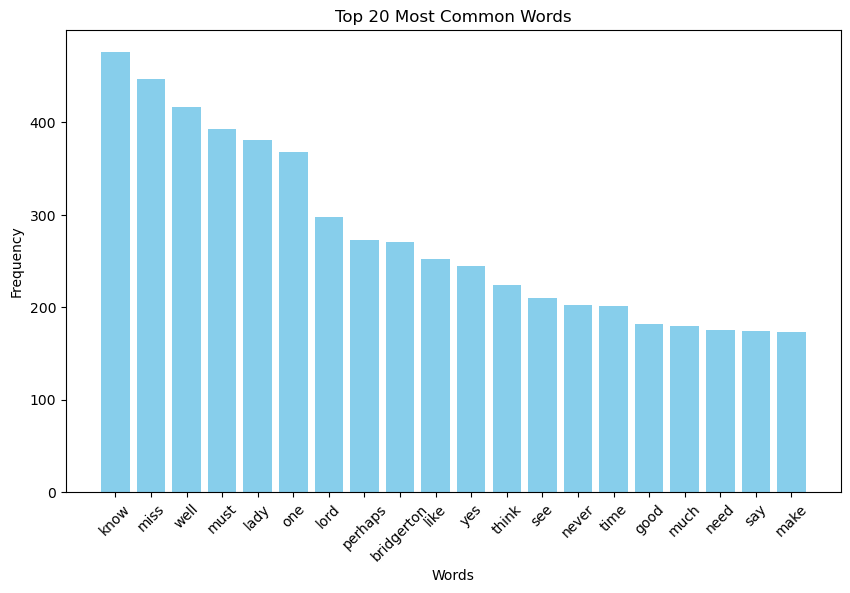

In [121]:
#Exploratory Data Analysis 
#Word frequency Analysis - most common words used and frequencies
from collections import Counter
import matplotlib.pyplot as plt

#Combine all words to a single list and remove stopwords, set can use update, so convert to set
stop_words = set(stopwords.words('english'))
custom_stop_words = ['oh','us','shall','may','ucu','could','would','quite','might']
stop_words.update(custom_stop_words)
all_words = [word.lower() for episode in df['Words'] for word in episode if word.lower() not in stop_words]
print(stop_words)
#calculate word frequencies
word_counts = Counter(all_words)
word_freq_df = pd.DataFrame(word_counts.items(), columns=['word', 'frequency']).sort_values(by='frequency', ascending=False)

#barchart to visualize 
top_words = word_freq_df.head(20)
plt.figure(figsize=(10, 6))
plt.bar(top_words['word'], top_words['frequency'], color='skyblue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 Most Common Words')
plt.xticks(rotation=45)
plt.show()

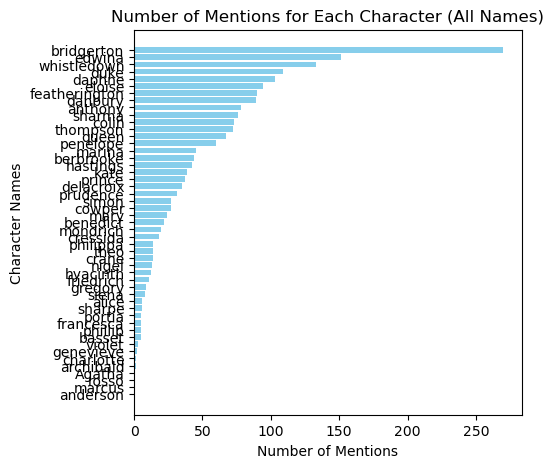

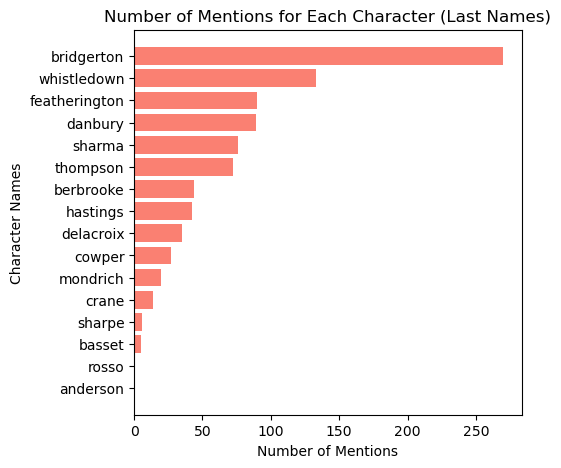

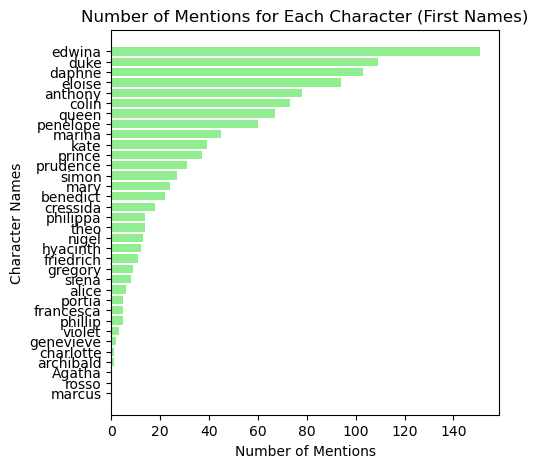

In [122]:
#let's look at character mentions in the transcripts (number of times someones name has been mentioned)
# Define character names (lowercase for matching)
character_first_names = [
    'daphne', 'simon', 'duke', 'anthony', 'benedict',
    'colin', 'eloise', 'penelope', 'violet', 'Agatha', 'queen', 
    'charlotte', 'marina', 'portia', 'archibald', 'philippa', 'prudence',
    'francesca', 'gregory', 'hyacinth', 'siena', 'rosso', 'genevieve',
    'prince', 'friedrich', 'alice', 'nigel', 'kate', 'mary', 'edwina', 'cressida', 'theo', 'marcus', 'phillip'
]
character_last_names = [
     'bridgerton', 'basset', 'hastings','featherington', 'danbury', 'thompson', 'delacroix',
    'mondrich', 'berbrooke', 'sharma', 'cowper', 'rosso', 'whistledown', 'sharpe', 'anderson', 'crane'
]

character_names = [
    'daphne', 'simon', 'duke', 'anthony', 'benedict',
    'colin', 'eloise', 'penelope', 'violet', 'Agatha', 'queen', 
    'charlotte', 'marina', 'portia', 'archibald', 'philippa', 'prudence',
    'francesca', 'gregory', 'hyacinth', 'siena', 'rosso', 'genevieve',
    'prince', 'friedrich', 'alice', 'nigel', 'kate', 'mary', 'edwina', 'cressida', 'theo', 'marcus',
    'phillip','bridgerton', 'basset', 'hastings','featherington', 'danbury', 'thompson', 'delacroix',
    'mondrich', 'berbrooke', 'sharma', 'cowper', 'rosso', 'whistledown', 'sharpe', 'anderson', 'crane'
]
# Count character mentions in all words
character_mentions = {name: all_words.count(name) for name in character_names}
character_mentions_last = {name: all_words.count(name) for name in character_last_names}
character_mentions_first = {name: all_words.count(name) for name in character_first_names}

# Sort the dictionary by values in descending order
sorted_character_mentions = dict(sorted(character_mentions.items(), key=lambda x: x[1], reverse=True))
sorted_character_mentions_last = dict(sorted(character_mentions_last.items(), key=lambda x: x[1], reverse=True))
sorted_character_mentions_first = dict(sorted(character_mentions_first.items(), key=lambda x: x[1], reverse=True))

# Extract character names and their mentions
characters = list(sorted_character_mentions.keys())
mentions = list(sorted_character_mentions.values())
characters_last = list(sorted_character_mentions_last.keys())
mentions_last = list(sorted_character_mentions_last.values())
characters_first = list(sorted_character_mentions_first.keys())
mentions_first = list(sorted_character_mentions_first.values())

# Plot the graph for all names
plt.figure(figsize=(5, 5))
plt.barh(characters, mentions, color='skyblue')
plt.xlabel('Number of Mentions')
plt.ylabel('Character Names')
plt.title('Number of Mentions for Each Character (All Names)')
plt.gca().invert_yaxis()  # Invert y-axis to show the character with the highest mentions at the top
plt.show()
# Plot the graph for last names
plt.figure(figsize=(5, 5))
plt.barh(characters_last, mentions_last, color='salmon')
plt.xlabel('Number of Mentions')
plt.ylabel('Character Names')
plt.title('Number of Mentions for Each Character (Last Names)')
plt.gca().invert_yaxis()  # Invert y-axis to show the character with the highest mentions at the top
plt.show()

# Plot the graph for first names
plt.figure(figsize=(5, 5))
plt.barh(characters_first, mentions_first, color='lightgreen')
plt.xlabel('Number of Mentions')
plt.ylabel('Character Names')
plt.title('Number of Mentions for Each Character (First Names)')
plt.gca().invert_yaxis()  # Invert y-axis to show the character with the highest mentions at the top
plt.show()

The above shows that the main character mentions for seasons 1 & 2 by first name are "Edwina", "Duke", "Daphne", "Eloise", "Anthony", "Colin", "Queen charlotte", and "Penelope", "Marina", and "Kate". By last name it's not surprising that the "Brigerton", "Featherington", "Whistledown", "Danbury" and "Sharma" families have the most mentions. These names represent the main characters in the series. 

## Preprocess for LDA Model: 

* Tokenize
* Remove "stop words"
* Lemmatize
* Bigram/Trigrams identification
* Term Frequency-Inverse Document Frequency (TF-IDF) - how many times a word appears in an episode mutliplied by the inverse frequency of the word across each episode
* Create Dictionary
* Bag of Words Vector creation

In [98]:
#df['Words'] already contains all the words in tokenized format, make sure all words are lower case
tokenized_words = [[word.lower() for word in sentence] for sentence in df['Words']]
filtered_words = [[word for word in sentence if word not in stop_words and len(word)>=3] for sentence in tokenized_words]
#lemmatize
lemmatized_words = [[wnl.lemmatize(word) for word in sentence] for sentence in filtered_words]

In [99]:
#data to use for bigrams/trigrams
df_words = lemmatized_words
#bigrams and trigrams 
bigram_phrases = gensim.models.Phrases(df_words, min_count=5, threshold=100)
trigram_phrases = gensim.models.Phrases(bigram_phrases[df_words], threshold=100)

bigram = gensim.models.phrases.Phraser(bigram_phrases)
trigram = gensim.models.phrases.Phraser(trigram_phrases)

def make_bigrams(episodes):
    return([bigram[episode] for episode in episodes])

def make_trigrams(episodes):
    return ([trigram[bigram[episode]] for episode in episodes])

data_bigrams = make_bigrams(df_words)
data_bigrams_trigrams = make_trigrams(data_bigrams)

#Note - bigrams and trigrams are identified using "_" like drawing_room. 
#print(data_bigrams_trigrams[0])


In [100]:
#TF-IDF Removal
from gensim.models import TfidfModel
id2word = Dictionary(data_bigrams_trigrams)
episodes = data_bigrams_trigrams
corpus = [id2word.doc2bow(episode) for episode in episodes]

tfidf = TfidfModel(corpus, id2word=id2word)

low_value = 0.03  # threshold for episodes
words = []
words_missing_in_tfidf = set()

for i, bow in enumerate(corpus):
    tfidf_dict = dict(tfidf[bow])
    bow_ids = set(id for id, _ in bow)
    tfidf_ids = set(tfidf_dict.keys())
    
    # Identify low-value words
    low_value_words = [id for id, value in tfidf_dict.items() if value < low_value]
    
    # Collect words to be dropped
    drops = set(low_value_words) | words_missing_in_tfidf
    
    # Append words to the words list
    words.extend(id2word[item] for item in drops)
    
    # Find words missing in tfidf
    words_missing_in_tfidf = bow_ids - tfidf_ids
    
    # Filter out low-value words and words missing in tfidf
    corpus[i] = [b for b in bow if b[0] not in drops]


# Modeling

* Create LDA Model (Topic clusters) holding 1 episode out of corpus
* Evaluate Model Coherence
* Visualize Clusters
* Test on unseen data (last episode)


In [111]:
lda_model_b = gensim.models.ldamodel.LdaModel(corpus=corpus[:-1], #give all but the last episode to model
                                           id2word=id2word,
                                           num_topics=12,
                                           random_state=123,
                                           update_every=1,
                                           chunksize=8,
                                           passes=10,
                                           alpha="auto")

num_top_words = 10
for idx, topic in lda_model_b.print_topics(num_words=num_top_words):
    print(f'Topic: {idx}')
    print(f'  Top words: {topic}')

# Calculate coherence score to evaluate the model
coherence_model_lda_b = CoherenceModel(model=lda_model_b, texts=lemmatized_words, dictionary=id2word, coherence='c_v')
coherence_lda_b = coherence_model_lda.get_coherence()
print(f'\nCoherence Score: {coherence_lda_b}')

Topic: 0
  Top words: 0.017*"grace" + 0.012*"thompson" + 0.012*"marina" + 0.010*"duchess" + 0.007*"wed" + 0.007*"teach" + 0.007*"carriage" + 0.006*"outcome" + 0.006*"married" + 0.006*"hastings"
Topic: 1
  Top words: 0.027*"grace" + 0.014*"daphne" + 0.011*"marina" + 0.010*"thompson" + 0.010*"duchess" + 0.009*"acquaintance" + 0.008*"mr_colson" + 0.007*"duke" + 0.007*"clyvedon" + 0.006*"simon"
Topic: 2
  Top words: 0.019*"whistledown" + 0.011*"majesty" + 0.011*"grace" + 0.009*"story" + 0.009*"queen" + 0.008*"ball" + 0.007*"duke" + 0.006*"decision" + 0.006*"madame_delacroix" + 0.006*"crane"
Topic: 3
  Top words: 0.025*"duke" + 0.020*"berbrooke" + 0.020*"daphne" + 0.014*"maid" + 0.013*"grace" + 0.010*"hastings" + 0.009*"prince" + 0.009*"remind" + 0.009*"finch" + 0.007*"thompson"
Topic: 4
  Top words: 0.000*"grace" + 0.000*"duke" + 0.000*"marina" + 0.000*"daphne" + 0.000*"lady" + 0.000*"berbrooke" + 0.000*"duchess" + 0.000*"thompson" + 0.000*"know" + 0.000*"miss"
Topic: 5
  Top words: 0.031*

# Cluster Visualization

Visualizing the clusters reveals the following: 
Cluster 1 shows topics such as: Wedding, Queen, Diamond, Edwina, and Feeling which centers on key themes in the series (getting married, finding the diamond, paying attention to feelings)
Cluster 2 shows topics such as : Lord, Lady, Bridgerton, Whistledown which centers on the formal tone of the series 

Names of characters do not show up in all clusters, with names like Edwina only showing up in a couple of clusters including 1 and 7. This suggests she's a focus in some episodes but not others. 

Before using TF-IDF and bigram/trigram idenficiation, the clusters were less clear. Even now with more data (such as adding season 3 transcripts once released), I would expect the model to improve clustering capability into more clear topics/themes. 

In [109]:
# Create the pyLDAvis visualization
pyLDAvis.enable_notebook()

#lda_display = pyLDAvis.gensim_models.prepare(lda_model, bow_corpus, d, mds="mmds", R=12)
lda_display = pyLDAvis.gensim_models.prepare(lda_model_b, corpus, id2word, mds="mmds", R=12)


'''WARNING'''
'''This code breaks jupyter notebook ribbons if cell is ran without comment. To re-enable, comment out display line'''
# Display the visualization
#pyLDAvis.display(lda_display)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


'This code breaks jupyter notebook ribbons if cell is ran without comment. To re-enable, comment out display line'

In [110]:
#Test model on unseen data:
test_doc = corpus[-1] #last episode
test_vector = lda_model_b[test_doc]
#print(test_vector) #shows topic and degree that topic is represented

def sort_vector(vector):
    vector.sort(key=lambda x: x[1]) #sort list based on index 1
    vector.reverse()
    return (vector)
new_vector = sort_vector(test_vector)
print(new_vector) #shows topic and degree topic is represented sorted by highest representation

[(2, 0.33710048), (5, 0.30339435), (3, 0.1394038), (0, 0.07691629), (6, 0.06502539), (7, 0.028615905), (8, 0.02623447), (1, 0.023108557)]


Earlier we defined topic 2 as: 
  Top words: 0.019*"whistledown" + 0.011*"majesty" + 0.011*"grace" + 0.009*"story" + 0.009*"queen" + 0.008*"ball" + 0.007*"duke" + 0.006*"decision" + 0.006*"madame_delacroix" + 0.006*"crane"

Some key topics in the last episode of season 2 include the reveal of who whistledown is, whether they will be caught by the queen and a final decision for Anthony regarding his love interest or the decision for whistledown to continue their craft. The top words:  "Whistledown", "queen", and "decision" help with this topic summary but could likely be improved further with more data. 